<a href="https://colab.research.google.com/github/leilaabdel/mammogram-compression-representation/blob/master/notebooks/autoencoder_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Data

In [8]:
# import the necessary packages
import h5py
import tensorflow
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
ROOT = '/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT'
DATA_ROOT = '/content/drive/MyDrive/Machine-Learning-Projects/ddsm-updated'
VIEW = "MLO"
ABNORMALITY = "mass"
HDF5_PATH = f"{DATA_ROOT}/HDF5_datasets/ddsm-{ABNORMALITY}-preprocessed-{VIEW}.h5"


In [3]:
f = h5py.File(HDF5_PATH, 'r')
f.keys()

<KeysViewHDF5 ['train-breast_density', 'train-mass_margins', 'train-mass_shape', 'train-pathology', 'train-raw-imgs', 'train-roi', 'train-roi_mask', 'train-side']>

In [4]:
x_train = f['train-raw-imgs']
x_train.shape

(637, 1024, 1024)

# Visulize Some Samples

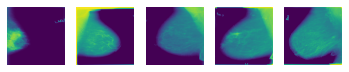

In [7]:
NUM_TO_VISUALIZE = 5
random_indices = np.random.randint(0 , len(x_train) , size=NUM_TO_VISUALIZE)
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  plt.imshow(x_train[random_indices[i]])



# Convolutional Autoencoder (Regular)

In [5]:

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")
  



  	# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
   

   		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [6]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
x_train = f['train-raw-imgs']
x_train = np.expand_dims(x_train , 3)
x_train, x_test, x_train, x_test = train_test_split(x_train, x_train, test_size=0.2, random_state=42)

[INFO] building autoencoder...


In [9]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")

# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 1

(encoder, decoder, autoencoder) = ConvAutoencoder.build(x_train.shape[1], x_train.shape[2], x_train.shape[3])
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	x_train, x_train,
	validation_data=(x_test, x_test),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...
Epoch 1/25
509/509 [==============================] - 27s 54ms/step - loss: 0.0391 - val_loss: 0.0319
Epoch 2/25
509/509 [==============================] - 27s 53ms/step - loss: 0.0241 - val_loss: 0.0230
Epoch 3/25
509/509 [==============================] - 27s 52ms/step - loss: 0.0196 - val_loss: 0.0177
Epoch 4/25
509/509 [==============================] - 27s 52ms/step - loss: 0.0163 - val_loss: 0.0179
Epoch 5/25
509/509 [==============================] - 27s 53ms/step - loss: 0.0138 - val_loss: 0.0132
Epoch 6/25
509/509 [==============================] - 27s 53ms/step - loss: 0.0122 - val_loss: 0.0152
Epoch 7/25
509/509 [==============================] - 27s 52ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 8/25
509/509 [==============================] - 27s 52ms/step - loss: 0.0103 - val_loss: 0.0136
Epoch 9/25
509/509 [==============================] - 27s 52ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 10/25
509/509 [==============================

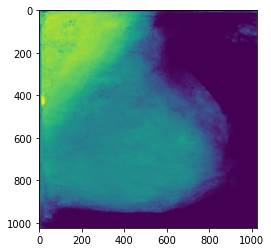

In [18]:
pred = autoencoder.predict(x_test[0:2])
plt.imshow(np.squeeze(pred[1]))
